In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam,SGD,RMSprop
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
from efficientnet_pytorch import EfficientNet
import gc

1.8.0+cu111


In [2]:
seed = 529 #沛茵生日

# path

In [3]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# load data

In [4]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

In [5]:
X_train_all = torch.load('X_train_吳啟聖教的方法.pt')
X_test = torch.load('X_test_吳啟聖教的方法.pt')
X_train_all.shape,X_test.shape
gc.collect()

20

In [6]:
Y_train_all,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train_all.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Dishes'}

# help functions

In [7]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

# 靜音部分消除
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram



from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

def 找超參數(search_iteration=30,max_epochs=30):
    import optuna
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler,direction='maximize')
    for i in tqdm(range(search_iteration)):
        trial = study.ask()
        lr = trial.suggest_uniform('lr',1e-5,1e-2)
        valid_size = trial.suggest_uniform('valid_size',0.1,0.5)
        batch_size = trial.suggest_int("batch_size", 16, 128)
        X_train, X_valid , y_train, y_valid = train_test_split(X_train_all, Y_train_all,
                                                               test_size = valid_size, 
                                                               random_state = 1,
                                                               stratify=Y_train_all)
        trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
        vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
        train_iter = DataLoader(trainset,batch_size=batch_size,num_workers=4)
        vaild_iter = DataLoader(vaildset,batch_size=batch_size,num_workers=4)
        model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=6)
        model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        device = 'cuda:0'
        model = model.to(device)
        model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
        optimizer = Adam(model.parameters(),lr=lr)
        loss_fn = nn.BCEWithLogitsLoss()
        model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=max_epochs,log_interval=1,device=device)
        model.eval()
        cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
        study.tell(trial,acc)
        print(study.best_params,study.best_value)
    return study.best_params,study.best_value

# train valid split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid , y_train, y_valid = train_test_split(X_train_all, Y_train_all, 
                                                       test_size = 0.1, 
                                                       random_state = seed,
                                                       stratify=Y_train_all)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([1079, 1, 80, 157])
torch.Size([120, 1, 80, 157])
0    180
1    180
2    180
3    180
5    180
4    179
dtype: int64
0    20
1    20
2    20
3    20
4    20
5    20
dtype: int64


#  create pytorch dataloader and save

In [9]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [10]:
import torch.hub
model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=64)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.fc = nn.Sequential(
    nn.Linear(64,64),
    nn.SELU(inplace=True),
    #nn.LeakyReLU()
    nn.Dropout(0.5),#三個臭皮匠勝過一個諸葛亮
    nn.Linear(64,6))
print(model)
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        print(m,'初始化')
        nn.init.xavier_uniform_(m.weight)
# forward test
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

torch.Size([32, 6])

# def train loop

In [11]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_auc = -np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_auc'][-1] >= current_auc:
                best_model = deepcopy(model.eval())
                current_auc = history['valid_auc'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

In [12]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

In [13]:
optimizer = Adam(model.parameters(),lr=5e-5)
loss_fn = nn.BCEWithLogitsLoss()

  1%|          | 1/100 [00:13<22:06, 13.40s/it]

epoch:0 train_loss:0.7584 valid_loss:0.5684 train_auc:0.1957 valid_auc:0.2760
有進步


  2%|▏         | 2/100 [00:19<14:32,  8.91s/it]

epoch:1 train_loss:0.5926 valid_loss:0.4515 train_auc:0.2549 valid_auc:0.3125
有進步
epoch:2 train_loss:0.4917 valid_loss:0.4012 train_auc:0.3321 valid_auc:0.4740
有進步


  4%|▍         | 4/100 [00:30<10:47,  6.74s/it]

epoch:3 train_loss:0.4481 valid_loss:0.3712 train_auc:0.3659 valid_auc:0.5365
有進步


  5%|▌         | 5/100 [00:36<10:04,  6.37s/it]

epoch:4 train_loss:0.4195 valid_loss:0.3500 train_auc:0.4135 valid_auc:0.5807
有進步


  6%|▌         | 6/100 [00:42<09:41,  6.18s/it]

epoch:5 train_loss:0.4003 valid_loss:0.3324 train_auc:0.4163 valid_auc:0.6406
有進步


  7%|▋         | 7/100 [00:47<09:17,  6.00s/it]

epoch:6 train_loss:0.3810 valid_loss:0.3159 train_auc:0.4874 valid_auc:0.6875
有進步


  8%|▊         | 8/100 [00:53<09:06,  5.94s/it]

epoch:7 train_loss:0.3608 valid_loss:0.3002 train_auc:0.5337 valid_auc:0.7109
有進步


  9%|▉         | 9/100 [00:59<08:52,  5.85s/it]

epoch:8 train_loss:0.3524 valid_loss:0.2892 train_auc:0.5549 valid_auc:0.7031


 10%|█         | 10/100 [01:04<08:38,  5.77s/it]

epoch:9 train_loss:0.3363 valid_loss:0.2763 train_auc:0.5780 valid_auc:0.7031
epoch:10 train_loss:0.3339 valid_loss:0.2641 train_auc:0.5960 valid_auc:0.7188
有進步


 12%|█▏        | 12/100 [01:17<08:54,  6.07s/it]

epoch:11 train_loss:0.3212 valid_loss:0.2535 train_auc:0.6343 valid_auc:0.7344
有進步


 13%|█▎        | 13/100 [01:22<08:40,  5.98s/it]

epoch:12 train_loss:0.3136 valid_loss:0.2452 train_auc:0.6457 valid_auc:0.7344
有進步


 14%|█▍        | 14/100 [01:28<08:23,  5.86s/it]

epoch:13 train_loss:0.2987 valid_loss:0.2357 train_auc:0.6465 valid_auc:0.7422
有進步


 15%|█▌        | 15/100 [01:34<08:19,  5.88s/it]

epoch:14 train_loss:0.2969 valid_loss:0.2268 train_auc:0.6664 valid_auc:0.7500
有進步
epoch:15 train_loss:0.2834 valid_loss:0.2194 train_auc:0.6752 valid_auc:0.7500
有進步


 17%|█▋        | 17/100 [01:45<07:58,  5.76s/it]

epoch:16 train_loss:0.2765 valid_loss:0.2137 train_auc:0.6995 valid_auc:0.7578
有進步


 18%|█▊        | 18/100 [01:51<07:45,  5.67s/it]

epoch:17 train_loss:0.2740 valid_loss:0.2070 train_auc:0.6892 valid_auc:0.7917
有進步


 19%|█▉        | 19/100 [01:56<07:39,  5.67s/it]

epoch:18 train_loss:0.2650 valid_loss:0.2032 train_auc:0.7175 valid_auc:0.8151
有進步


 20%|██        | 20/100 [02:02<07:36,  5.71s/it]

epoch:19 train_loss:0.2561 valid_loss:0.1918 train_auc:0.7401 valid_auc:0.8281
有進步


 21%|██        | 21/100 [02:08<07:29,  5.69s/it]

epoch:20 train_loss:0.2560 valid_loss:0.1914 train_auc:0.7406 valid_auc:0.8203


 22%|██▏       | 22/100 [02:14<07:26,  5.72s/it]

epoch:21 train_loss:0.2494 valid_loss:0.1858 train_auc:0.7533 valid_auc:0.8203


 23%|██▎       | 23/100 [02:19<07:20,  5.72s/it]

epoch:22 train_loss:0.2424 valid_loss:0.1826 train_auc:0.7498 valid_auc:0.8438
有進步


 24%|██▍       | 24/100 [02:25<07:09,  5.65s/it]

epoch:23 train_loss:0.2293 valid_loss:0.1761 train_auc:0.7781 valid_auc:0.8359


 25%|██▌       | 25/100 [02:31<07:05,  5.67s/it]

epoch:24 train_loss:0.2305 valid_loss:0.1691 train_auc:0.7721 valid_auc:0.8672
有進步


 26%|██▌       | 26/100 [02:36<07:03,  5.72s/it]

epoch:25 train_loss:0.2289 valid_loss:0.1687 train_auc:0.7791 valid_auc:0.8438


 27%|██▋       | 27/100 [02:42<06:56,  5.70s/it]

epoch:26 train_loss:0.2179 valid_loss:0.1650 train_auc:0.7780 valid_auc:0.8516


 28%|██▊       | 28/100 [02:48<06:50,  5.71s/it]

epoch:27 train_loss:0.2182 valid_loss:0.1616 train_auc:0.8008 valid_auc:0.8594


 29%|██▉       | 29/100 [02:53<06:44,  5.69s/it]

epoch:28 train_loss:0.2189 valid_loss:0.1589 train_auc:0.8166 valid_auc:0.8516


 30%|███       | 30/100 [02:59<06:43,  5.77s/it]

epoch:29 train_loss:0.2092 valid_loss:0.1578 train_auc:0.7998 valid_auc:0.8854
有進步


 31%|███       | 31/100 [03:05<06:32,  5.69s/it]

epoch:30 train_loss:0.2082 valid_loss:0.1532 train_auc:0.8182 valid_auc:0.8698


 32%|███▏      | 32/100 [03:11<06:27,  5.69s/it]

epoch:31 train_loss:0.2015 valid_loss:0.1527 train_auc:0.8068 valid_auc:0.8594


 33%|███▎      | 33/100 [03:18<06:47,  6.09s/it]

epoch:32 train_loss:0.2016 valid_loss:0.1491 train_auc:0.8136 valid_auc:0.8750


 34%|███▍      | 34/100 [03:23<06:36,  6.01s/it]

epoch:33 train_loss:0.1983 valid_loss:0.1449 train_auc:0.8403 valid_auc:0.8698


 35%|███▌      | 35/100 [03:29<06:24,  5.91s/it]

epoch:34 train_loss:0.1906 valid_loss:0.1403 train_auc:0.8241 valid_auc:0.8958
有進步


 36%|███▌      | 36/100 [03:35<06:13,  5.83s/it]

epoch:35 train_loss:0.1915 valid_loss:0.1402 train_auc:0.8443 valid_auc:0.8750


 37%|███▋      | 37/100 [03:40<06:03,  5.78s/it]

epoch:36 train_loss:0.1849 valid_loss:0.1394 train_auc:0.8261 valid_auc:0.9036
有進步


 38%|███▊      | 38/100 [03:46<05:59,  5.79s/it]

epoch:37 train_loss:0.1815 valid_loss:0.1364 train_auc:0.8535 valid_auc:0.8880


 39%|███▉      | 39/100 [03:52<05:50,  5.74s/it]

epoch:38 train_loss:0.1780 valid_loss:0.1426 train_auc:0.8430 valid_auc:0.8385


 40%|████      | 40/100 [03:57<05:41,  5.70s/it]

epoch:39 train_loss:0.1768 valid_loss:0.1324 train_auc:0.8531 valid_auc:0.8854


 41%|████      | 41/100 [04:03<05:41,  5.79s/it]

epoch:40 train_loss:0.1772 valid_loss:0.1393 train_auc:0.8506 valid_auc:0.8672


 42%|████▏     | 42/100 [04:09<05:34,  5.76s/it]

epoch:41 train_loss:0.1760 valid_loss:0.1237 train_auc:0.8590 valid_auc:0.9115
有進步


 43%|████▎     | 43/100 [04:15<05:27,  5.74s/it]

epoch:42 train_loss:0.1687 valid_loss:0.1216 train_auc:0.8609 valid_auc:0.9062


 44%|████▍     | 44/100 [04:21<05:24,  5.80s/it]

epoch:43 train_loss:0.1643 valid_loss:0.1211 train_auc:0.8660 valid_auc:0.8776


 45%|████▌     | 45/100 [04:27<05:22,  5.87s/it]

epoch:44 train_loss:0.1645 valid_loss:0.1212 train_auc:0.8722 valid_auc:0.8880


 46%|████▌     | 46/100 [04:33<05:20,  5.93s/it]

epoch:45 train_loss:0.1593 valid_loss:0.1223 train_auc:0.8785 valid_auc:0.8958


 47%|████▋     | 47/100 [04:39<05:10,  5.85s/it]

epoch:46 train_loss:0.1522 valid_loss:0.1205 train_auc:0.8814 valid_auc:0.8958


 48%|████▊     | 48/100 [04:44<05:02,  5.81s/it]

epoch:47 train_loss:0.1538 valid_loss:0.1199 train_auc:0.8884 valid_auc:0.8880


 49%|████▉     | 49/100 [04:50<04:54,  5.77s/it]

epoch:48 train_loss:0.1532 valid_loss:0.1142 train_auc:0.8958 valid_auc:0.8984


 50%|█████     | 50/100 [04:56<04:45,  5.72s/it]

epoch:49 train_loss:0.1495 valid_loss:0.1131 train_auc:0.8866 valid_auc:0.8776


 51%|█████     | 51/100 [05:01<04:41,  5.75s/it]

epoch:50 train_loss:0.1463 valid_loss:0.1117 train_auc:0.8961 valid_auc:0.8802


 52%|█████▏    | 52/100 [05:07<04:37,  5.78s/it]

epoch:51 train_loss:0.1444 valid_loss:0.1170 train_auc:0.8939 valid_auc:0.8880


 53%|█████▎    | 53/100 [05:13<04:31,  5.78s/it]

epoch:52 train_loss:0.1448 valid_loss:0.1081 train_auc:0.9044 valid_auc:0.9062


 54%|█████▍    | 54/100 [05:20<04:44,  6.19s/it]

epoch:53 train_loss:0.1368 valid_loss:0.1081 train_auc:0.9123 valid_auc:0.8932


 55%|█████▌    | 55/100 [05:26<04:34,  6.10s/it]

epoch:54 train_loss:0.1330 valid_loss:0.1069 train_auc:0.8875 valid_auc:0.8958
epoch:55 train_loss:0.1337 valid_loss:0.1075 train_auc:0.8982 valid_auc:0.9115
有進步


 57%|█████▋    | 57/100 [05:37<04:13,  5.90s/it]

epoch:56 train_loss:0.1318 valid_loss:0.1122 train_auc:0.9041 valid_auc:0.8958


 58%|█████▊    | 58/100 [05:43<04:03,  5.80s/it]

epoch:57 train_loss:0.1296 valid_loss:0.1078 train_auc:0.9096 valid_auc:0.8932


 59%|█████▉    | 59/100 [05:49<03:56,  5.78s/it]

epoch:58 train_loss:0.1274 valid_loss:0.1057 train_auc:0.9114 valid_auc:0.8958


 60%|██████    | 60/100 [05:54<03:48,  5.71s/it]

epoch:59 train_loss:0.1269 valid_loss:0.0997 train_auc:0.9108 valid_auc:0.9010


 61%|██████    | 61/100 [06:00<03:43,  5.73s/it]

epoch:60 train_loss:0.1247 valid_loss:0.1024 train_auc:0.9289 valid_auc:0.8958


 62%|██████▏   | 62/100 [06:06<03:38,  5.76s/it]

epoch:61 train_loss:0.1189 valid_loss:0.1036 train_auc:0.9279 valid_auc:0.9036


 63%|██████▎   | 63/100 [06:12<03:31,  5.72s/it]

epoch:62 train_loss:0.1194 valid_loss:0.1035 train_auc:0.9239 valid_auc:0.8880


 64%|██████▍   | 64/100 [06:17<03:25,  5.72s/it]

epoch:63 train_loss:0.1195 valid_loss:0.1009 train_auc:0.9243 valid_auc:0.9115
有進步


 65%|██████▌   | 65/100 [06:23<03:21,  5.76s/it]

epoch:64 train_loss:0.1144 valid_loss:0.1049 train_auc:0.9283 valid_auc:0.8932


 66%|██████▌   | 66/100 [06:29<03:13,  5.70s/it]

epoch:65 train_loss:0.1136 valid_loss:0.1055 train_auc:0.9276 valid_auc:0.8958


 67%|██████▋   | 67/100 [06:34<03:06,  5.64s/it]

epoch:66 train_loss:0.1113 valid_loss:0.1016 train_auc:0.9393 valid_auc:0.8958


 68%|██████▊   | 68/100 [06:40<03:00,  5.64s/it]

epoch:67 train_loss:0.1078 valid_loss:0.0922 train_auc:0.9430 valid_auc:0.9036


 69%|██████▉   | 69/100 [06:46<02:55,  5.66s/it]

epoch:68 train_loss:0.1078 valid_loss:0.0918 train_auc:0.9430 valid_auc:0.9245
有進步


 70%|███████   | 70/100 [06:51<02:49,  5.65s/it]

epoch:69 train_loss:0.1068 valid_loss:0.1025 train_auc:0.9393 valid_auc:0.8880


 71%|███████   | 71/100 [06:57<02:45,  5.71s/it]

epoch:70 train_loss:0.1034 valid_loss:0.0970 train_auc:0.9485 valid_auc:0.9036


 72%|███████▏  | 72/100 [07:03<02:40,  5.73s/it]

epoch:71 train_loss:0.1016 valid_loss:0.0962 train_auc:0.9491 valid_auc:0.8958


 73%|███████▎  | 73/100 [07:08<02:33,  5.68s/it]

epoch:72 train_loss:0.0971 valid_loss:0.0979 train_auc:0.9445 valid_auc:0.8776


 74%|███████▍  | 74/100 [07:14<02:26,  5.64s/it]

epoch:73 train_loss:0.1000 valid_loss:0.0910 train_auc:0.9491 valid_auc:0.8958


 75%|███████▌  | 75/100 [07:21<02:30,  6.01s/it]

epoch:74 train_loss:0.0968 valid_loss:0.1010 train_auc:0.9513 valid_auc:0.8880


 76%|███████▌  | 76/100 [07:27<02:25,  6.05s/it]

epoch:75 train_loss:0.0970 valid_loss:0.0899 train_auc:0.9509 valid_auc:0.8958


 77%|███████▋  | 77/100 [07:33<02:16,  5.95s/it]

epoch:76 train_loss:0.0903 valid_loss:0.0857 train_auc:0.9550 valid_auc:0.9115


 78%|███████▊  | 78/100 [07:38<02:08,  5.86s/it]

epoch:77 train_loss:0.0918 valid_loss:0.0950 train_auc:0.9577 valid_auc:0.9115


 79%|███████▉  | 79/100 [07:44<02:02,  5.81s/it]

epoch:78 train_loss:0.0882 valid_loss:0.1063 train_auc:0.9583 valid_auc:0.8620


 80%|████████  | 80/100 [07:50<01:56,  5.84s/it]

epoch:79 train_loss:0.0864 valid_loss:0.0941 train_auc:0.9706 valid_auc:0.8776


 81%|████████  | 81/100 [07:56<01:51,  5.87s/it]

epoch:80 train_loss:0.0842 valid_loss:0.0857 train_auc:0.9642 valid_auc:0.9193


 82%|████████▏ | 82/100 [08:01<01:44,  5.80s/it]

epoch:81 train_loss:0.0835 valid_loss:0.1010 train_auc:0.9666 valid_auc:0.9062


 83%|████████▎ | 83/100 [08:07<01:37,  5.76s/it]

epoch:82 train_loss:0.0849 valid_loss:0.0965 train_auc:0.9642 valid_auc:0.8958


 84%|████████▍ | 84/100 [08:13<01:31,  5.72s/it]

epoch:83 train_loss:0.0786 valid_loss:0.0899 train_auc:0.9675 valid_auc:0.8880


 85%|████████▌ | 85/100 [08:18<01:25,  5.71s/it]

epoch:84 train_loss:0.0772 valid_loss:0.0900 train_auc:0.9761 valid_auc:0.8984


 86%|████████▌ | 86/100 [08:25<01:21,  5.84s/it]

epoch:85 train_loss:0.0789 valid_loss:0.0848 train_auc:0.9693 valid_auc:0.8958


 87%|████████▋ | 87/100 [08:30<01:15,  5.82s/it]

epoch:86 train_loss:0.0773 valid_loss:0.0881 train_auc:0.9688 valid_auc:0.8854


 88%|████████▊ | 88/100 [08:36<01:09,  5.80s/it]

epoch:87 train_loss:0.0755 valid_loss:0.0893 train_auc:0.9693 valid_auc:0.8984


 89%|████████▉ | 89/100 [08:42<01:03,  5.79s/it]

epoch:88 train_loss:0.0702 valid_loss:0.0883 train_auc:0.9767 valid_auc:0.8906


 90%|█████████ | 90/100 [08:48<00:58,  5.85s/it]

epoch:89 train_loss:0.0723 valid_loss:0.1038 train_auc:0.9816 valid_auc:0.8542


 91%|█████████ | 91/100 [08:54<00:52,  5.82s/it]

epoch:90 train_loss:0.0684 valid_loss:0.0856 train_auc:0.9789 valid_auc:0.8932


 92%|█████████▏| 92/100 [08:59<00:46,  5.83s/it]

epoch:91 train_loss:0.0675 valid_loss:0.0943 train_auc:0.9761 valid_auc:0.8906
epoch:92 train_loss:0.0640 valid_loss:0.0851 train_auc:0.9789 valid_auc:0.9062


 94%|█████████▍| 94/100 [09:11<00:34,  5.75s/it]

epoch:93 train_loss:0.0674 valid_loss:0.0965 train_auc:0.9807 valid_auc:0.8802
epoch:94 train_loss:0.0678 valid_loss:0.0796 train_auc:0.9853 valid_auc:0.9297
有進步


 95%|█████████▌| 95/100 [09:17<00:28,  5.78s/it]

epoch:95 train_loss:0.0685 valid_loss:0.0981 train_auc:0.9798 valid_auc:0.9010


 97%|█████████▋| 97/100 [09:29<00:17,  5.99s/it]

epoch:96 train_loss:0.0625 valid_loss:0.0870 train_auc:0.9798 valid_auc:0.8958


 98%|█████████▊| 98/100 [09:35<00:11,  5.94s/it]

epoch:97 train_loss:0.0626 valid_loss:0.0779 train_auc:0.9835 valid_auc:0.9297
有進步


 99%|█████████▉| 99/100 [09:41<00:05,  5.90s/it]

epoch:98 train_loss:0.0593 valid_loss:0.0847 train_auc:0.9798 valid_auc:0.8984


100%|██████████| 100/100 [09:46<00:00,  5.87s/it]

epoch:99 train_loss:0.0583 valid_loss:0.0779 train_auc:0.9853 valid_auc:0.9062


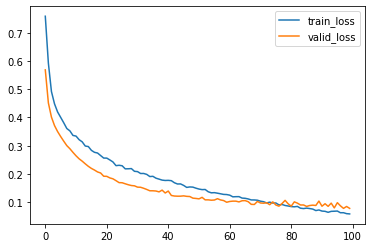

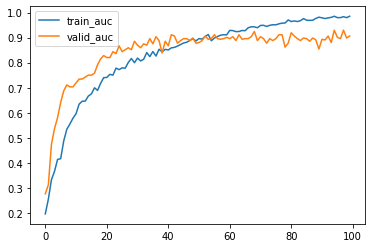

In [14]:
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

# model infernce test

In [15]:
model.eval()
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 34/34 [00:02<00:00, 15.61it/s]

0.9684893419833179


,Barking,Howling,Crying,COSmoke,GlassBreaking,Dishes
0,170,5,1,1,0,1
1,2,169,5,0,0,0
2,5,4,173,1,0,2
3,1,0,0,177,0,0
4,1,0,0,0,179,0
5,1,2,1,1,0,177


In [16]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

0.9333333333333333


,Barking,Howling,Crying,COSmoke,GlassBreaking,Dishes
0,18,1,0,1,0,0
1,0,17,1,0,0,1
2,1,1,19,0,0,0
3,1,0,0,19,0,0
4,0,0,0,0,20,0
5,0,1,0,0,0,19


# submit

In [17]:
print(X_test.shape[0])

10000


In [18]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,-4.589404,-7.103025,-5.449708,-7.272630,-5.890907,3.474462
1,public_00002,-3.237309,-5.631329,-6.532974,-5.641322,-6.938568,3.150492
2,public_00003,1.617429,-3.309885,-5.771729,-3.733042,-4.878004,-4.212007
3,public_00004,-3.209992,-7.340166,-4.773160,-6.267713,-3.775096,1.359558
4,public_00005,-2.450636,-2.718092,0.419123,-2.947644,-2.521025,-4.369037
...,...,...,...,...,...,...,...
29995,private_19996,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29996,private_19997,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29997,private_19998,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29998,private_19999,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000


In [19]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[3.14525324e-04, 2.54685222e-05, 1.33054689e-04, 2.14954001e-05,
        8.55893974e-05, 9.99419867e-01],
       [1.67844081e-03, 1.53177901e-04, 6.21751132e-05, 1.51654805e-04,
        4.14447583e-05, 9.97913107e-01],
       [9.83226321e-01, 7.12440179e-03, 6.07551144e-04, 4.66631194e-03,
        1.48498768e-03, 2.89042624e-03],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [20]:
sample_submit.iloc[:,1:] = a
sample_submit

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.000315,0.000025,0.000133,0.000021,0.000086,0.999420
1,public_00002,0.001678,0.000153,0.000062,0.000152,0.000041,0.997913
2,public_00003,0.983226,0.007124,0.000608,0.004666,0.001485,0.002890
3,public_00004,0.010169,0.000164,0.002130,0.000478,0.005779,0.981281
4,public_00005,0.047426,0.036297,0.836258,0.028852,0.044203,0.006964
...,...,...,...,...,...,...,...
29995,private_19996,0.166656,0.166656,0.166656,0.166656,0.166656,0.166722
29996,private_19997,0.166656,0.166656,0.166656,0.166656,0.166656,0.166722
29997,private_19998,0.166656,0.166656,0.166656,0.166656,0.166656,0.166722
29998,private_19999,0.166656,0.166656,0.166656,0.166656,0.166656,0.166722


In [21]:
sample_submit.iloc[122]

Filename         public_00123
Barking               0.01261
Howling              0.001419
Crying               0.001449
COSmoke               0.00033
GlassBreaking        0.001056
Other                0.983135
Name: 122, dtype: object

In [22]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [23]:
acc

0.9333333333333333

In [24]:
# save
sample_submit.to_csv(f'senet20_20210605_random_state{seed}_validacc_{acc}.csv',index=False)
torch.save(model.state_dict(),f'senet20_20210605_random_state{seed}_validacc_{acc}.pt')
#print('done')